In [1]:
import sys
import os
import gzip
from optparse import OptionParser
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import pearsonr, spearmanr, linregress
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial' 
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
## Sample information
data_folder = "../data/GATA1_lib_HBG_2LP/"
figure_folder = "../figures/"
reps = ["rep1", "rep2"]
bins = ["bin1", "bin2", "bin3", "bin4"]
LPs = ["0kb", "10kb"]
n_reps = len(reps)
n_bins = len(bins)
sorting_gates = pd.read_csv(data_folder+"sorting_gate_info.txt", sep="\t")

In [4]:
## Read barcode reference
dBC_file = pd.read_csv("dBCs.txt", sep="\t", header=None)
eBC_file = pd.read_csv("total_library_final_with_BC.txt", sep="\t")
eBC_dict = {x:y for x,y in zip(eBC_file["eBC"].to_list(), eBC_file["name"].to_list())}
dBC_dict = {x:y for x,y in zip(dBC_file[1].to_list(), dBC_file[0].to_list())}

eBCs = list(set(eBC_dict))
dBCs = list(set(dBC_dict))

In [5]:
# Combine data across bins for each replicate
all_datas = []
for rep in reps:
    datas = []
    for bin in bins:
        sample = rep+"_"+bin
        sample_dir = data_folder+sample+"_barcode_summary.txt"
        datas.append(pd.read_csv(sample_dir, sep = "\t"))
    combined_data = pd.concat(
        objs=(iDF.set_index(["CRE", "LP", "rBC"]) for iDF in datas),
        axis=1, 
        join='outer'
    ).reset_index()
    combined_data.columns = ["CRE", "LP", "rBC"] + bins
    combined_data = combined_data.fillna(0)
    combined_data = combined_data[combined_data["LP"].isin(LPs)]
    combined_data["sum"] = combined_data["bin1"] + combined_data["bin2"] + combined_data["bin3"] + combined_data["bin4"]
    combined_data["rep"] = rep
    all_datas.append(combined_data)

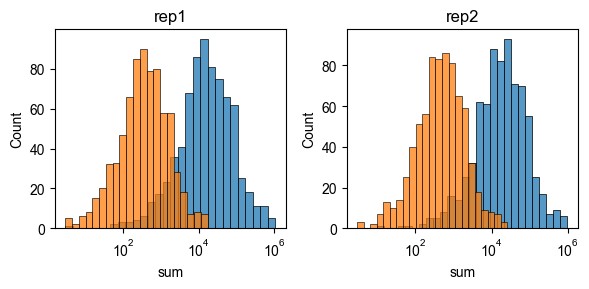

In [6]:
## Check read/rBC distribution across library members before any filtering
fig, axs = plt.subplots(ncols=n_reps, nrows=1, figsize=(3*n_reps, 3))
for ax, i in zip(axs, range(n_reps)):
    rep_data = all_datas[i]
    rep = reps[i]
    sns.histplot(data=rep_data.groupby(["CRE", "LP"])["sum"].sum(), log_scale=True, ax=ax)
    sns.histplot(data=rep_data.groupby(["CRE", "LP"])["rBC"].nunique(), log_scale=True, ax=ax)
    ax.set_title(rep)
plt.tight_layout()

Text(5, 70, 'median rBCs:473')

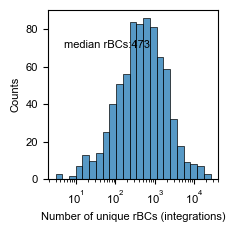

In [34]:
## Check the number of unique events per eBC-dBC
plt.figure(figsize=(2.2, 2.2))
sns.histplot(data=rep_data.groupby(["CRE", "LP"])["rBC"].nunique(), log_scale=True)
plt.xlabel("Number of unique rBCs (integrations)", fontsize=8)
plt.ylabel("Counts", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
median_rBCs = int(np.median(rep_data.groupby(["CRE", "LP"])["rBC"].nunique()))
plt.text(5, 70, f"median rBCs:{median_rBCs}", fontsize=8)

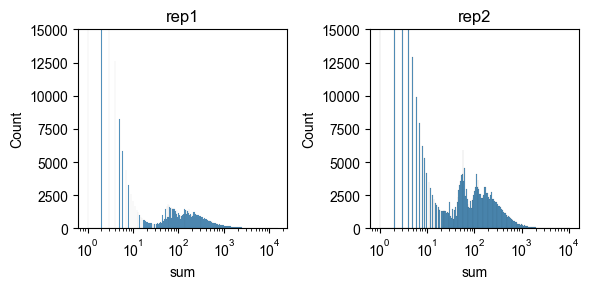

In [35]:
## Check read coverage for rBCs
fig, axs = plt.subplots(ncols=n_reps, nrows=1, figsize=(3*n_reps, 3))
for ax, i in zip(axs, range(n_reps)):
    rep_data = all_datas[i]
    rep = reps[i]
    sns.histplot(data=rep_data.groupby(["CRE", "LP", "rBC"])["sum"].sum(), log_scale=True, ax=ax)
    ax.set_ylim(0,15000)
    ax.set_title(rep)
plt.tight_layout()

In [9]:
## Remove rBCs with <20 reads, and remove those with template switching
s=20
filtered_datas = []
for data in all_datas:
    filtered_datas.append(data[data["sum"]>s].reset_index(drop=True).sort_values(by="sum", ascending=False).drop_duplicates(subset=["rBC", "CRE"], keep="first"))

In [10]:
filtered_datas[0].groupby("LP")["rBC"].nunique().sum()

120941

Text(1, 70, 'median rBCs:63')

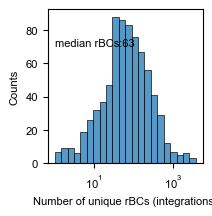

In [36]:
## Check the number of unique events per eBC-dBC after filtering
plt.figure(figsize=(2,2))
sns.histplot(data=filtered_datas[0].groupby(["CRE", "LP"])["rBC"].nunique(), log_scale=True)
plt.xlabel("Number of unique rBCs (integrations)", fontsize=8)
plt.ylabel("Counts", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
median_rBCs = int(np.median(filtered_datas[0].groupby(["CRE", "LP"])["rBC"].nunique()))
plt.text(1, 70, f"median rBCs:{median_rBCs}", fontsize=8)

In [12]:
## Check library coverage after rBC filtering
library_coverage = len(filtered_datas[0].groupby(["CRE", "LP"]).sum())/len(eBCs)/len(LPs)
print(f"library coverage: {library_coverage}")

library coverage: 0.9804177545691906


In [13]:
## Calculate activity for each eBC-dBC
grouped_datas = []
for i in range(n_reps):
    rep = reps[i]
    filtered_data = filtered_datas[i]
    grouped_data = filtered_data.groupby(["CRE", "LP"])[[*bins, "sum"]].sum().reset_index()
    grouped_data["n_rBCs"] = filtered_data.groupby(["CRE", "LP"])["rBC"].nunique().reset_index()["rBC"]
    ### Normalize read counts by total number of reads in that bin
    for bin in bins:
        bin_percentage = sorting_gates[(sorting_gates["rep"] == rep) & (sorting_gates["bin"] == bin)]["percentage"].iloc[0]
        total_reads = grouped_data[bin].sum()
        grouped_data[bin+"_norm"] = grouped_data[bin]/total_reads
    ### Calculate weighted average across bins 
    grouped_data["norm_sum"] = 0
    for bin in bins:
        cell_percentage = sorting_gates[(sorting_gates["rep"] == rep) & (sorting_gates["bin"] == bin)]["percentage"].iloc[0]
        grouped_data["norm_sum"] = grouped_data["norm_sum"] + grouped_data[bin+"_norm"]*cell_percentage
    for bin in bins:
        cell_percentage = sorting_gates[(sorting_gates["rep"] == rep) & (sorting_gates["bin"] == bin)]["percentage"].iloc[0]
        grouped_data[bin+"_prop"] = grouped_data[bin+"_norm"]*cell_percentage / grouped_data["norm_sum"]
    grouped_data["exp"] = 0
    for bin in bins:
        MFI = sorting_gates[(sorting_gates["rep"] == rep) & (sorting_gates["bin"] == bin)]["MFI"].iloc[0]
        grouped_data["exp"] += MFI*grouped_data[bin+"_prop"]
    grouped_data["rep"] = rep
    grouped_datas.append(grouped_data)
    

In [14]:
## Combine data across replicates
combined_data = pd.concat(
    objs=(iDF.set_index(["CRE", "LP", "rep"]) for iDF in grouped_datas),
    join='inner'
).reset_index()
combined_data_wide = combined_data.pivot(index=["CRE", "LP"], columns = "rep", values = ["n_rBCs", "exp"])
combined_data_wide.columns = combined_data_wide.columns.map('_'.join)
combined_data_wide = combined_data_wide.reset_index()
## Calculate mean and std expression level across replicates
combined_data_wide["mean_exp"] = combined_data_wide.iloc[:,-n_reps:].mean(axis=1)
combined_data_wide["std_exp"] = combined_data_wide.iloc[:,-n_reps-1:-1].std(axis=1)
combined_data_wide["CV"] = combined_data_wide["std_exp"]/combined_data_wide["mean_exp"]
combined_data_wide["mean_n_rBCs"] = combined_data_wide.iloc[:, 2:2+n_reps].mean(axis=1)

<Figure size 500x500 with 0 Axes>

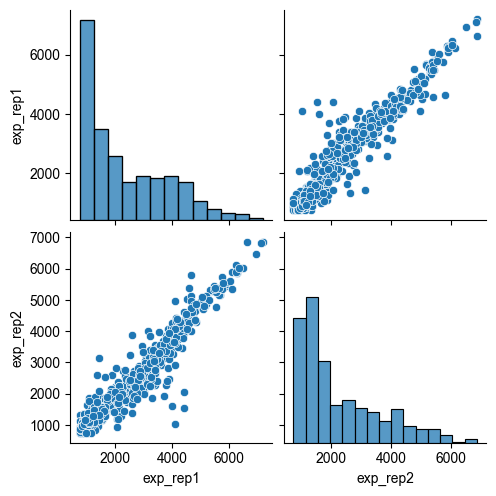

In [15]:
## Check reproducibility between replicates
plt.figure(figsize=(5,5))
sns.pairplot(data=combined_data_wide.iloc[:, -n_reps-4:-4])

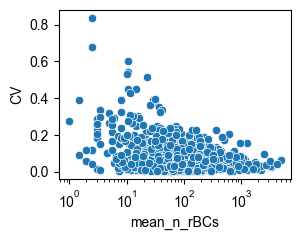

In [16]:
## Check relationship between number of rBCs and CV
plt.figure(figsize=(3,2.2))
sns.scatterplot(data=combined_data_wide, x="mean_n_rBCs", y="CV")
plt.xscale("log")

In [17]:
## Filter library members with too fewer integrations
t = 10
filtered_combined_data_wide = combined_data_wide[combined_data_wide[["n_rBCs_rep1", "n_rBCs_rep2"]].min(axis=1)>t]

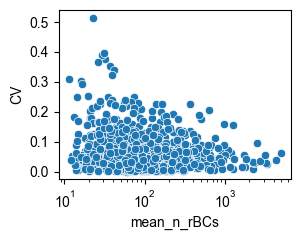

In [18]:
## Re-check relationship between number of rBCs and CV
plt.figure(figsize=(3,2.2))
sns.scatterplot(data=filtered_combined_data_wide, x="mean_n_rBCs", y="CV")
plt.xscale("log")

<Figure size 500x500 with 0 Axes>

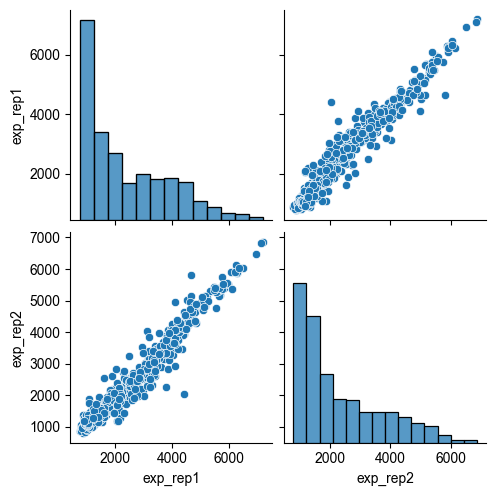

In [19]:
## Re-check reproducibility
plt.figure(figsize=(5,5))
sns.pairplot(data=filtered_combined_data_wide[["exp_rep1", "exp_rep2"]])

In [20]:
## Generate a colormap for distances

distance_2LP = {
    '0kb': "plum",  
    '10kb': "purple", 
}

In [21]:
## Check library coverage after final filtering
library_coverage = len(filtered_combined_data_wide.groupby(["CRE", "LP"]).sum())/len(eBCs)/len(LPs)
print(f"library coverage: {library_coverage}")

library coverage: 0.8668407310704961


In [22]:
## Normalize activity by scrambled controls

filtered_combined_data_wide_annotated = pd.merge(filtered_combined_data_wide, eBC_file, left_on="CRE", right_on = "name")

for LP in LPs:
    mean_scrambled = filtered_combined_data_wide_annotated.loc[(filtered_combined_data_wide_annotated["group"] == "scrambled") & (filtered_combined_data_wide_annotated["LP"] == LP), "mean_exp"].mean()
    filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "norm_mean_exp"] = filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "mean_exp"]/mean_scrambled
    filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "norm_exp_rep1"] = filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "exp_rep1"]/mean_scrambled
    filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "norm_exp_rep2"] = filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["LP"] == LP, "exp_rep2"]/mean_scrambled
 

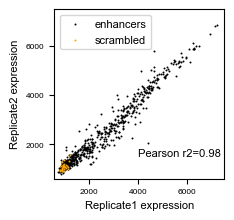

In [23]:
## Generate reproducibility figure for Figure 2B
plt.figure(figsize=(2.2, 2.2))
sns.scatterplot(data=filtered_combined_data_wide_annotated, x="exp_rep1", y="exp_rep2", linewidth=0, s=2, color="black")
sns.scatterplot(data=filtered_combined_data_wide_annotated[filtered_combined_data_wide_annotated["group"] == "scrambled"], x="exp_rep1", y="exp_rep2", linewidth=0, s=2, color="orange")
pearson_r,p = pearsonr(filtered_combined_data_wide["exp_rep1"], filtered_combined_data_wide["exp_rep2"])
spearman_r,p = spearmanr(filtered_combined_data_wide["exp_rep1"], filtered_combined_data_wide["exp_rep2"])
plt.text(4000,1500, s=f"Pearson r2={pearson_r:.2f}", fontsize=8)
#plt.text(1000,6500, s=f"spearman r2={spearman_r:.2f}", fontsize=8)
plt.legend(labels=["enhancers", "scrambled"], fontsize=8, loc="upper left")
plt.xlim(600,7500)
plt.ylim(600,7500)
plt.xlabel("Replicate1 expression", fontsize=8)
plt.ylabel("Replicate2 expression", fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
#plt.legend(fontsize=6)
#plt.tight_layout()
plt.savefig(figure_folder+"reproducibility.svg", dpi=300)

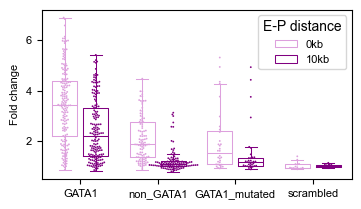

In [24]:
## Generate box+swarm plot for Figure 2D
plt.figure(figsize=(4, 2.2))
sns.boxplot(data=filtered_combined_data_wide_annotated, x="group", y="norm_mean_exp", hue="LP", order=["GATA1", "non_GATA1", "GATA1_mutated", "scrambled"], linewidth=0.75, palette=distance_2LP, showcaps=True, fliersize=0, dodge=True, fill=False, gap=.2)
sns.swarmplot(data=filtered_combined_data_wide_annotated, x="group", y="norm_mean_exp", hue="LP", order=["GATA1", "non_GATA1", "GATA1_mutated", "scrambled"], linewidth=0, palette=distance_2LP,size=1.3, dodge=True, legend=False)

# Adjust legend
plt.legend(title='E-P distance', loc='upper right', fontsize=8, bbox_to_anchor=(1, 1))
plt.xlabel("")
plt.ylabel("Fold change", fontsize=8)
#plt.legend(loc="upper right", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig(figure_folder+"normalized_enhancer_per_group.svg", dpi=300)

(array([0., 2., 4., 6., 8.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8')])

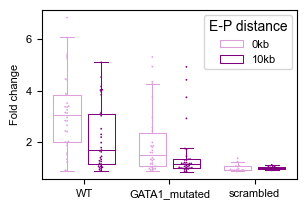

In [25]:
## Check effects of GATA1 mutations
mut_lists = filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["CRE"].str.contains("mut")]["CRE"].str.split("_",expand=True)[0].drop_duplicates().to_list()


filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["CRE"].str.contains("mut"),"mut_type"] = "GATA1_mutated"
filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["CRE"].isin(mut_lists),"mut_type"] = "WT"
filtered_combined_data_wide_annotated.loc[filtered_combined_data_wide_annotated["CRE"].str.contains("scrambled"),"mut_type"] = "scrambled"

plt.figure(figsize=(3.3, 2.2))
sns.boxplot(data=filtered_combined_data_wide_annotated, x="mut_type", y="norm_mean_exp", hue="LP", order=["WT","GATA1_mutated", "scrambled"], linewidth=0.75, palette=distance_2LP, showcaps=True, fliersize=0, dodge=True, fill=False, gap=.2)
sns.swarmplot(data=filtered_combined_data_wide_annotated, x="mut_type", y="norm_mean_exp", hue="LP", order=["WT", "GATA1_mutated", "scrambled"], linewidth=0, palette=distance_2LP,size=1.3, dodge=True, legend=False)

# Adjust legend
plt.legend(title='E-P distance', loc='upper right', bbox_to_anchor=(1, 1), fontsize=8)
plt.xlabel("")
plt.ylabel("Fold change", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

In [26]:
## Convert dataframe from long to wide format
activity_per_LP = filtered_combined_data_wide_annotated[["CRE", "LP", "mean_exp", "norm_mean_exp", "flag", "group", "mut_type"]].pivot(columns="LP", values=["mean_exp", "norm_mean_exp"], index=["CRE", "flag", "group", "mut_type"])
activity_per_LP.columns = activity_per_LP.columns.map('_'.join)
activity_per_LP = activity_per_LP.dropna().reset_index()

<Figure size 220x220 with 0 Axes>

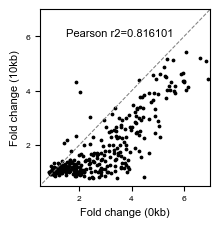

In [27]:
## Check 0kb and 10kb relationship (Figure 2E)
plt.figure(figsize=(2.2, 2.2))
g = sns.lmplot(activity_per_LP, x="norm_mean_exp_0kb", y="norm_mean_exp_10kb", height=2.5, aspect=0.95, legend=False, fit_reg=False, scatter_kws={"s": 3, "alpha":1, "color":"black"})
sns.lineplot(x=[0,7],y=[0,7], color='grey', linestyle='--',legend=None, linewidth=0.75)
#sns.lineplot(x=[0,7], y=[1,1], color='grey', linestyle='--', legend=None, linewidth=0.75)

for ax in g.axes.flatten():
    # Set spines visibility
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    
plt.xlabel("Fold change (0kb)", fontsize=8)
plt.ylabel("Fold change (10kb)", fontsize=8)
plt.xlim(0.5, 7)
plt.ylim(0.5, 7)

## Calculate correlation between 0kb and 10kb
r,p = pearsonr(activity_per_LP[activity_per_LP["group"].isin(["non_GATA1", "GATA1"])]["norm_mean_exp_0kb"], activity_per_LP[activity_per_LP["group"].isin(["non_GATA1", "GATA1"])]["norm_mean_exp_10kb"])
plt.text(1.5,6,f"Pearson r2={r:2f}", fontsize=8)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.savefig(figure_folder+"DLP1_GATA_library_group_regression.svg", dpi=300)

GATA1 enhancers: 0.6720273682105921 0.09739231969390394 0.8083340539637539 4.104316649483876e-39
non-GATA1 enhancers: 0.23386078710299618 0.7157449698593894 0.4750674311749078 5.908812130690825e-07
All enhancers: 0.6568220726339333 0.03366374500489533 0.816100504784221 2.438848502770838e-64


<Figure size 220x220 with 0 Axes>

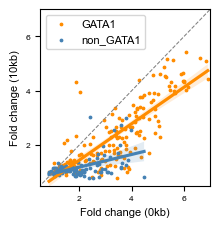

In [28]:
## Check 0kb and 10kb relationship with linear regression (Figure 2F)
plt.figure(figsize=(2.2, 2.2))
g = sns.lmplot(activity_per_LP, x="norm_mean_exp_0kb", y="norm_mean_exp_10kb", hue = "group",hue_order=["GATA1", "non_GATA1"], palette={"GATA1":"darkorange", "non_GATA1":"steelblue"}, height=2.5, aspect=0.95, legend=False, fit_reg=True, scatter_kws={"s": 3, "alpha":1})
sns.lineplot(x=[0,7],y=[0,7], color='grey', linestyle='--',legend=None, linewidth=0.75)
#sns.lineplot(x=[0,7], y=[1,1], color='grey', linestyle='--', legend=None, linewidth=0.75)
plt.legend(loc="upper left", fontsize=6)
for ax in g.axes.flatten():
    # Set spines visibility
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
plt.xlabel("Fold change (0kb)", fontsize=8)
plt.ylabel("Fold change (10kb)", fontsize=8)
plt.xlim(0.5, 7)
plt.ylim(0.5, 7)

plt.legend(loc="upper left", fontsize=8)
s1,i1,r1,p1,err1=linregress(activity_per_LP[activity_per_LP["group"] == "GATA1"]["norm_mean_exp_0kb"], activity_per_LP[activity_per_LP["group"] == "GATA1"]["norm_mean_exp_10kb"])
s2,i2,r2,p2, err2=linregress(activity_per_LP[activity_per_LP["group"] == "non_GATA1"]["norm_mean_exp_0kb"], activity_per_LP[activity_per_LP["group"] == "non_GATA1"]["norm_mean_exp_10kb"])
s,i,r,p,err = linregress(activity_per_LP[activity_per_LP["group"].isin(["non_GATA1", "GATA1"])]["norm_mean_exp_0kb"], activity_per_LP[activity_per_LP["group"].isin(["non_GATA1", "GATA1"])]["norm_mean_exp_10kb"])
print("GATA1 enhancers:", s1,i1,r1,p1)
print("non-GATA1 enhancers:", s2,i2,r2,p2)
print("All enhancers:", s,i,r,p)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.savefig(figure_folder+"DLP1_GATA_library_two_group_regression.svg", dpi=300)

In [29]:
activity_per_LP.loc[activity_per_LP["group"].isin(["GATA1", "non_GATA1"]), "x"] = activity_per_LP[activity_per_LP["group"].isin(["GATA1", "non_GATA1"])]["norm_mean_exp_0kb"]
activity_per_LP.loc[activity_per_LP["group"].isin(["GATA1", "non_GATA1"]), "y_exp"] = activity_per_LP[activity_per_LP["group"].isin(["GATA1", "non_GATA1"])]["norm_mean_exp_10kb"]
activity_per_LP.loc[activity_per_LP["group"].isin(["GATA1", "non_GATA1"]), "y_pred1"] = list(activity_per_LP[activity_per_LP["group"].isin(["GATA1", "non_GATA1"])]["norm_mean_exp_0kb"]*s + i)
activity_per_LP.loc[activity_per_LP["group"].isin(["GATA1"]), "y_pred2"] = list(activity_per_LP[activity_per_LP["group"].isin(["GATA1"])]["norm_mean_exp_0kb"]*s1 + i1)
activity_per_LP.loc[activity_per_LP["group"].isin(["non_GATA1"]), "y_pred2"] = list(activity_per_LP[activity_per_LP["group"].isin(["non_GATA1"])]["norm_mean_exp_0kb"]*s2 + i2)


In [30]:
## Do a two-way ANOVA to figure out %variance explained by 0kb activity versus by TF binding

activity_0kb = activity_per_LP.loc[activity_per_LP["group"].isin(["GATA1", "non_GATA1"]), "norm_mean_exp_0kb"].to_list()
GATA1_binding = activity_per_LP.loc[activity_per_LP["group"].isin(["GATA1", "non_GATA1"]), "group"].to_list()
activity_10kb = activity_per_LP.loc[activity_per_LP["group"].isin(["GATA1", "non_GATA1"]), "norm_mean_exp_10kb"].to_list()
data = pd.DataFrame(zip(activity_0kb, GATA1_binding, activity_10kb), columns = ["activity_0kb", "GATA1_binding", "activity_10kb"])
model = ols('activity_10kb ~ activity_0kb + activity_0kb:C(GATA1_binding)', data=data).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Use Type II for balanced data
print(anova_table)

# Calculate variance explained
total_ss = anova_table['sum_sq'].sum()
anova_table['variance_explained'] = anova_table['sum_sq'] / total_ss
print(anova_table)

                                   sum_sq     df           F        PR(>F)
activity_0kb                   233.646394    1.0  600.344316  1.264421e-69
activity_0kb:C(GATA1_binding)   15.585575    1.0   40.046461  1.073940e-09
Residual                       101.577890  261.0         NaN           NaN
                                   sum_sq     df           F        PR(>F)  \
activity_0kb                   233.646394    1.0  600.344316  1.264421e-69   
activity_0kb:C(GATA1_binding)   15.585575    1.0   40.046461  1.073940e-09   
Residual                       101.577890  261.0         NaN           NaN   

                               variance_explained  
activity_0kb                             0.666020  
activity_0kb:C(GATA1_binding)            0.044427  
Residual                                 0.289553  


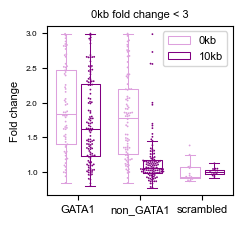

In [31]:
## Check 0kb and 10kb activity among weak enhancers (Figure 2G)
plt.figure(figsize=(2.4, 2.2))
sns.boxplot(data=filtered_combined_data_wide_annotated[filtered_combined_data_wide_annotated["norm_mean_exp"]<3], x="group", y="norm_mean_exp", hue="LP", order=["GATA1", "non_GATA1","scrambled"], hue_order=["0kb", "10kb"], linewidth=0.75, palette=distance_2LP, showcaps=True, fliersize=0, dodge=True, fill=False, gap=.2)
sns.swarmplot(data=filtered_combined_data_wide_annotated[filtered_combined_data_wide_annotated["norm_mean_exp"]<3], x="group", y="norm_mean_exp", hue="LP", order=["GATA1", "non_GATA1","scrambled"], hue_order=["0kb", "10kb"], linewidth=0, palette=distance_2LP,size=1.3, dodge=True, legend=False)
plt.title("0kb fold change < 3", fontsize=8)
plt.xlabel("")
plt.ylabel("Fold change", fontsize=8)
plt.legend(loc="upper right", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=6)
#plt.ylim(0,7)
plt.savefig(figure_folder+"weak_enhancer_per_group.svg", dpi=300)


In [32]:
## Save enhancer activity table
activity_per_LP["fold_change"] = activity_per_LP["norm_mean_exp_10kb"]/activity_per_LP["norm_mean_exp_0kb"]
activity_per_LP.to_csv(data_folder+"activity_per_LP_summary.txt", sep="\t", index=None)

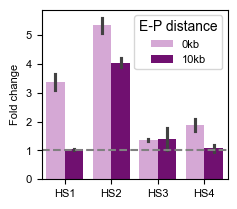

In [33]:
## Check activity of HS1,2,3,4 in library (Figure 2C)
positives = pd.melt(filtered_combined_data_wide_annotated, id_vars=["CRE", "group", "LP"], value_vars=["norm_exp_rep1", "norm_exp_rep2"])
names = ["HS1", "HS2", "HS3", "HS4"]
CREs = ["chr11:5275840-5276089", "chr11:5280597-5280846", "chr11:5284674-5284923", "chr11:5288127-5288376"]
positives.loc[positives["CRE"] == "chr11:5275840-5276089", "name"] = "HS1"
positives.loc[positives["CRE"] == "chr11:5280597-5280846", "name"] = "HS2"
positives.loc[positives["CRE"] == "chr11:5284674-5284923", "name"] = "HS3"
positives.loc[positives["CRE"] == "chr11:5288127-5288376", "name"] = "HS4"
positives.loc[positives["group"] == "scrambled", "name"] = "scrambled"
plt.figure(figsize=(2.4, 2.2))
ax = sns.barplot(positives, x="name", y="value", order=names, hue="LP", palette=distance_2LP)
#sns.swarmplot(positives, x="name", y="value", order=names, hue="LP", dodge=True, color="black", legend=False) 
plt.legend(title="E-P distance", fontsize=8)
plt.xlabel("")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel("Fold change", fontsize=8)
plt.axhline(y=1, color='grey', linestyle='--')
plt.savefig(figure_folder+"LCR_HS_foldchange.svg", dpi=300)